### Preprocessing

In [1]:
import pandas as pd

In [2]:
df = pd.read_table('data/pdbbind/index/INDEX_general_PL_data.2020',skiprows=4,sep=r'\s+',usecols=[0,4]).drop(0)
df = df.rename(columns={'#': 'name','release': 'affinity'})
df_refined = pd.read_table('data/pdbbind/index/INDEX_refined_data.2020',skiprows=4,sep=r'\s+',usecols=[0,4]).drop(0)
df_refined = df_refined.rename(columns={'#': 'name','release': 'affinity'})
df = pd.concat([df,df_refined])

In [3]:
quantities = ['ki','kd','ka','k1/2','kb','ic50','ec50']

In [4]:
from pint import UnitRegistry
ureg = UnitRegistry()

def to_uM(affinity):
    val = ureg(affinity)
    try:
        return val.m_as(ureg.uM)
    except Exception:
        pass
    
    try:
        return 1/val.m_as(1/ureg.uM)
    except Exception:
        pass

In [5]:
df['affinity_uM'] = df['affinity'].str.split('[=\~><]').str[1].apply(to_uM)
df['affinity_quantity'] = df['affinity'].str.split('[=\~><]').str[0]

<AxesSubplot:>

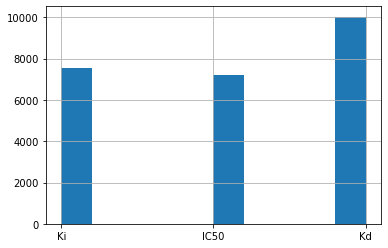

In [6]:
df['affinity_quantity'].hist()

In [7]:
df_filter = df[df['affinity_quantity'].str.lower().isin(quantities)]

In [8]:
df_complex = pd.read_parquet('data/pdbbind_complex.parquet')

In [19]:
import dask.array as da
import dask.dataframe as dd
from dask.bag import from_delayed
from dask import delayed
import pyarrow as pa
import pyarrow.parquet as pq

In [10]:
contacts_dask = da.from_npy_stack('data/pdbbind_contacts')
contacts_dask = contacts_dask.reshape(-1,contacts_dask.shape[-2]*contacts_dask.shape[-1])

In [11]:
df_complex.head()

name                                                seq  \
0  2lbv  MTVPDRSEIAGKWYVVALASNTEFFLREKDKMKMAMARISFLGEDE...   
1  1lt6  APQTITELCSEYRNTQIYTINDKILSYTESMAGKREMVIITFKSGE...   
2  4lwi  VETFAFQAEIAQLMSLIINTFYSNKEIFLRELISNSSDALDKIRYE...   
3  6oyz  VQLQESGGGLVQTGGSLTLSCATSGRSFSLYAMAWFRQAPGKEREF...   
4  4i11  GSFVEMVDNLRGKSGQGYYVEMTVGSPPQTLNILVDTGSSNFAVGA...   

                                              smiles  
0                          CCCCCCCCCCCCCCCCCCCC(=O)O  
1         O=[N+]([O-])c1cccc(OC2OC(CO)C(O)C(O)C2O)c1  
2  COc1ccc(-c2c(-c3cc(C(C)C)c(O)cc3O)noc2NC(=O)C2...  
3  COC1C(O)C(n2ccc(=O)[nH]c2=O)OC1C(OC1OC(C(=O)NC...  
4           CC1(C)Cc2ccccc2C(NC(Cc2ccccc2)C(=O)O)=N1

In [12]:
contacts_dask.blocks[1]

dask.array<blocks, shape=(438, 1048576), dtype=float32, chunksize=(438, 1048576), chunktype=numpy.ndarray>

In [76]:
np.where(contacts_dask.blocks[0].compute()[0])

(array([ 1046,  2578,  2579,  2582,  2584,  6144,  6145,  6146,  6149,
         6156,  6157,  6158,  6159,  6160,  6161,  6162,  6163,  6166,
         6168,  7173,  7174,  7175,  7176, 18432, 18433, 18434, 18435,
        18436, 18437, 18438, 19456, 19457, 19458, 19459, 19467, 19468,
        19469, 19472, 19473, 19474, 19475, 20498, 20499, 20502, 20504,
        24576, 24577, 24578, 24579, 24580, 24581, 24586, 24587, 24588,
        25090, 25091, 25092, 25093, 25603, 25604, 25605, 25606, 25607,
        25608, 26116, 26117, 33281, 33283, 33291, 33292, 43009, 43015,
        43016, 43017, 43018, 43019, 43020, 43021, 43022, 43023, 44046,
        44047, 44048, 44049, 44050, 44051, 44056, 45582, 45583, 45584,
        45585, 45586, 45587, 45592, 46606, 46607, 46608, 46609, 46610,
        46611, 46614, 46616, 48654, 48655, 49672, 49673, 49674, 49675,
        49676, 49677, 49678, 49679, 49680, 50696, 50697, 57350, 57351,
        57352, 57353, 57354, 58368, 58369, 58370, 58371, 58372, 58373,
      

In [121]:
def chunk_to_sparse(chunk, idx_chunk):
    res = df_complex.iloc[idx_chunk].copy()
    res['contacts'] = [np.where(a) for a in chunk]
    return res

partitions = [delayed(chunk_to_sparse)(b,k)
              for b,k in zip(contacts_dask.blocks, da.arange(contacts_dask.shape[0],chunks=contacts_dask.chunks[0:1]).blocks)
             ]

In [123]:
partitions[0].compute().head()

name                                                seq  \
0  2lbv  MTVPDRSEIAGKWYVVALASNTEFFLREKDKMKMAMARISFLGEDE...   
1  1lt6  APQTITELCSEYRNTQIYTINDKILSYTESMAGKREMVIITFKSGE...   
2  4lwi  VETFAFQAEIAQLMSLIINTFYSNKEIFLRELISNSSDALDKIRYE...   
3  6oyz  VQLQESGGGLVQTGGSLTLSCATSGRSFSLYAMAWFRQAPGKEREF...   
4  4i11  GSFVEMVDNLRGKSGQGYYVEMTVGSPPQTLNILVDTGSSNFAVGA...   

                                              smiles  \
0                          CCCCCCCCCCCCCCCCCCCC(=O)O   
1         O=[N+]([O-])c1cccc(OC2OC(CO)C(O)C(O)C2O)c1   
2  COc1ccc(-c2c(-c3cc(C(C)C)c(O)cc3O)noc2NC(=O)C2...   
3  COC1C(O)C(n2ccc(=O)[nH]c2=O)OC1C(OC1OC(C(=O)NC...   
4           CC1(C)Cc2ccccc2C(NC(Cc2ccccc2)C(=O)O)=N1   

                                            contacts  
0  ([1046, 2578, 2579, 2582, 2584, 6144, 6145, 61...  
1  ([514, 518, 520, 521, 522, 523, 525, 526, 546,...  
2  ([521, 523, 526, 542, 544, 546, 547, 548, 1041...  
3  ([35332, 35334, 35336, 35338, 35342, 35347, 35...  
4  ([36372, 36373, 36375, 36376, 36377, 36378, 36...

In [125]:
ddf = dd.from_delayed(partitions)

In [129]:
ddf_all = ddf.merge(df_filter, on='name').drop(columns=['affinity','affinity_quantity'],axis=1)

In [132]:
df_all_contacts = ddf_all.compute()

In [134]:
df_all_contacts['neg_log10_affinity_M'] = 6-np.log10(df_all_contacts['affinity_uM'])

In [136]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_all_contacts['affinity'] = scaler.fit_transform(df_all_contacts['neg_log10_affinity_M'].values.reshape(-1,1))
scaler.mean_, scaler.var_

(array([6.3455065]), array([3.57430038]))

In [138]:
df_all_contacts.drop(columns=['name'],axis=1).to_parquet('data/pdbbind_with_contacts.parquet')

In [127]:
df_all = df_complex.merge(df_filter,on='name').drop('affinity',axis=1)

In [128]:
df_all

name                                                seq  \
0      2lbv  MTVPDRSEIAGKWYVVALASNTEFFLREKDKMKMAMARISFLGEDE...   
1      1lt6  APQTITELCSEYRNTQIYTINDKILSYTESMAGKREMVIITFKSGE...   
2      4lwi  VETFAFQAEIAQLMSLIINTFYSNKEIFLRELISNSSDALDKIRYE...   
3      6oyz  VQLQESGGGLVQTGGSLTLSCATSGRSFSLYAMAWFRQAPGKEREF...   
4      4i11  GSFVEMVDNLRGKSGQGYYVEMTVGSPPQTLNILVDTGSSNFAVGA...   
...     ...                                                ...   
20822  2bok  IVGGQECKDGECPWQALLINEENEGFCGGTILSEFYILTAAHCLYQ...   
20823  4j46  GTIYPRNPAMYSEEARLKSFQNWPDYAHLTPRELASAGLYYTGIGD...   
20824  4j46  GTIYPRNPAMYSEEARLKSFQNWPDYAHLTPRELASAGLYYTGIGD...   
20825  2c80  DHIKVIYFNGRGRAESIRMTLVAAGVNYEDERISFQDWPKIKPTIP...   
20826  2c80  DHIKVIYFNGRGRAESIRMTLVAAGVNYEDERISFQDWPKIKPTIP...   

                                                  smiles  affinity_uM  \
0                              CCCCCCCCCCCCCCCCCCCC(=O)O        0.026   
1             O=[N+]([O-])c1cccc(OC2OC(CO)C(O)C(O)C2O)c1      500.000   
2      COc1ccc(-c2c(-c3cc(C(C)C)c(O)cc3O)noc2NC(=O)C2...        0.023   
3      COC1C(O)C(n2ccc(=O)[nH]c2=O)OC1C(OC1OC(C(=O)NC...        0.185   
4               CC1(C)Cc2ccccc2C(NC(Cc2ccccc2)C(=O)O)=N1       27.200   
...                                                  ...          ...   
20822  C[N+](C)(C)CCCN1C(=O)C2C(C1=O)C(c1ccc(C(=N)N)c...        0.280   
20823  CCC(C)C(NC(=O)C1CCCN1C(=O)C(NC(=O)C(C)[NH3+])C...        5.240   
20824  CCC(C)C(NC(=O)C1CCCN1C(=O)C(NC(=O)C(C)[NH3+])C...        5.240   
20825    CCCCCCSCC(NC(=O)CCC([NH3+])C(=O)O)C(=O)NCC(=O)O        4.700   
20826    CCCCCCSCC(NC(=O)CCC([NH3+])C(=O)O)C(=O)NCC(=O)O        4.700   

      affinity_quantity  
0                    Kd  
1                  IC50  
2                  IC50  
3                  IC50  
4                  IC50  
...                 ...  
20822                Ki  
20823                Ki  
20824                Ki  
20825                Kd  
20826                Kd  

[20827 rows x 5 columns]

In [14]:
df_all.to_parquet('data/pdbbind.parquet')

In [15]:
len(df_all)

20827